## Preprocessing and Logistic Regression for Binary Classification Problems | Vladimir Bogdanov

### Objective: for 38 indicators related to the grant application (the area of research of scientists, information on their academic background, the size of the grant, the area in which it is issued, etc.), to predict whether the application will be accepted. The DataNet includes information on 6,000 applications for grants that were submitted to the University of Melbourne between 2004 and 2008.

### A full version of the data with a large number of features can be found at https://www.kaggle.com/c/unimelb.

### The main aim of this notebook was to train in data preprocessing since it is crucial step of data analysis and common mistake is to pay too little attention to it. I'll wotk through: 
- processing of missing values
- handling of categorical attributes
- stratification
- class balancing
- scaling



In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
data = pd.read_csv('data.csv')
data.shape

(6000, 39)

In [3]:
X = data.drop('Grant.Status', 1)
y = data['Grant.Status']

Theory of LogReg briefly just to skip explanations further: 

Logistic regression predicts the probabilities of belonging to each class. The sum of logistic regression responses on a single object for all classes is one.

$$ \sum_{k=1}^K \pi_{ik} = 1, \quad \pi_k \equiv P\,(y_i = k \mid x_i, \theta), $$

where:
- $\pi_{ik}$ - probability of the object $x_i$ from sample $X$ to the class $k$
- $\theta$ - internal parameters of the algorithm, which are configured in the learning process, in the case of logistic regression - $w, b$

From this property of the model in the case of a binary classification, it is only necessary to calculate the probability of an object belonging to one of the classes (the second is calculated from the condition for the normalization of probabilities). This probability is calculated using the logistic function:

$$ P\,(y_i = 1 \mid x_i, \theta) = \frac{1}{1 + \exp(-w^T x_i-b)} $$

The parameters $ w $ and $ b $ are found as solutions of the following optimization problem:

L2-regularization:

$$ Q(X, y, \theta) = \frac{1}{2} w^T w + C \sum_{i=1}^l \log ( 1 + \exp(-y_i (w^T x_i + b ) ) ) \longrightarrow \min\limits_{w,b} $$

L1-regularization:

$$ Q(X, y, \theta) = \sum_{d=1}^D |w_d| + C \sum_{i=1}^l \log ( 1 + \exp(-y_i (w^T x_i + b ) ) ) \longrightarrow \min\limits_{w,b} $$

$C$ - This is a standard model hyperparameter that regulates how much the model is allowed to adjust to the data.

## Data preprocessing 

From the properties of this model it follows that:
- all $ X $ must be numerical data (if there are categories among them, they need to be converted into real numbers in some way)
- there should be no missing values among $ X $ (that is, all missing values must be filled in some way before applying the model)

Therefore, the basic step in preprocessing any dataset for logistic regression will be coding of categorical features, as well as removing or interpreting missing values (if one or the other exists).

In [4]:
data.head()

,Grant.Status,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,RFCD.Code.3,RFCD.Percentage.3,...,Dept.No..1,Faculty.No..1,With.PHD.1,No..of.Years.in.Uni.at.Time.of.Grant.1,Number.of.Successful.Grant.1,Number.of.Unsuccessful.Grant.1,A..1,A.1,B.1,C.1
0,1,21A,50A,A,230202.0,50.0,230203.0,30.0,230204.0,20.0,...,3098.0,31.0,Yes,>=0 to 5,2.0,0.0,0.0,4.0,2.0,0.0
1,1,4D,10A,D,320801.0,100.0,0.0,0.0,0.0,0.0,...,2553.0,25.0,Yes,>=0 to 5,3.0,1.0,0.0,2.0,0.0,0.0
2,0,NaN,NaN,NaN,320602.0,50.0,321004.0,30.0,321015.0,20.0,...,2813.0,25.0,NaN,Less than 0,1.0,5.0,0.0,7.0,2.0,0.0
3,0,51C,20C,A,291503.0,60.0,321402.0,40.0,0.0,0.0,...,2553.0,25.0,NaN,more than 15,2.0,1.0,5.0,6.0,9.0,1.0
4,0,24D,30B,NaN,380107.0,100.0,0.0,0.0,0.0,0.0,...,2923.0,25.0,NaN,Less than 0,0.0,2.0,0.0,0.0,0.0,0.0


It can be seen that there are both numeric and categorical characteristics in the dataset. Let's get lists of their names:

In [5]:
numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                'RFCD.Percentage.4', 'RFCD.Percentage.5',
                'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                'SEO.Percentage.4', 'SEO.Percentage.5',
                'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
categorical_cols = list(set(X.columns.values.tolist()) - set(numeric_cols))


Also, it contains missing values. The obvious solution is to exclude all data that have at least one missing value. Let's do it:

In [6]:
data.dropna().shape

(213, 39)

It is evident that then we will throw out almost all the data, and this method of solution in this case does not work.

Missing values can also be interpreted, for this there are several ways, they differ for categorical and material characteristics.

For real features:
- replace by 0 (this attribute will not contribute to the prediction for this object)
- replaced by the average (each missed attribute will give the same contribution as the average value of the attribute on the dataset)

For categorical:
- interpret the missing value as another category (this method is the most natural, since in the case of categories we have a unique opportunity not to lose information about the presence of missed values, please note that in case of material attributes this information is inevitably lost)

##  Processing of missing values.
### Let's do several steps to handle missing values: 
1. Fill in the missing real values in X with zeros and columns averages, name the received dataframes X_real_zeros and X_real_mean, respectively. To calculate the average, I'll use function calculate_means described below.
2. Convert all categorical characteristics in X to strings, the missing values must also be converted to any strings that are not categories (for example, 'NA'), the resulting dataframe is X_cat.

In [7]:
?np.nonzero

In [8]:
def calculate_means(numeric_data):
    means = np.zeros(numeric_data.shape[1])
    for j in range(numeric_data.shape[1]):
        to_sum = numeric_data.iloc[:,j]
        indices = np.nonzero(~numeric_data.iloc[:,j].isnull())[0]
        correction = np.amax(to_sum[indices])
        to_sum /= correction
        for i in indices:
            means[j] += to_sum[i]
        means[j] /= indices.size
        means[j] *= correction
    return pd.Series(means, numeric_data.columns)

In [9]:
X_real_zeros = data[numeric_cols].fillna(0)
X_real_mean = data[numeric_cols].fillna(calculate_means(data[numeric_cols]))

In [10]:
X_cat = data[categorical_cols]
X_cat = X_cat.fillna('NA').applymap(str)

print X_cat

          Country.of.Birth.1 SEO.Code.4 SEO.Code.5   B.1 SEO.Code.1  \
0                  Australia        0.0        0.0   2.0   780101.0   
1                  Australia        0.0        0.0   0.0   730112.0   
2                  Australia        0.0        0.0   2.0   730203.0   
3              Great Britain        0.0        0.0   9.0   730114.0   
4                  Australia        0.0        0.0   0.0   730108.0   
5              Great Britain        0.0        0.0   0.0   730211.0   
6              Great Britain        0.0        0.0   6.0   749903.0   
7                  Australia        0.0        0.0   3.0   751003.0   
8                         NA        0.0        0.0    NA   770703.0   
9                  Australia        0.0        0.0  31.0   730115.0   
10                 Australia        0.0        0.0   0.0   730106.0   
11                 Australia        0.0        0.0   2.0   730301.0   
12                 Australia        0.0        0.0   0.0   750307.0   
13    

## Transformation of categorical features

In the previous cell, I've divided our data set into two parts: one contains only physical characteristics, the other only categorical ones. It will be necessary to separate subsequent processing of this data, as well as for comparing the quality of work of certain methods.

To use the regression model, it also needed to convert the categorical characteristics into real ones. Let's consider the basic way of transformation categorical attributes in real: one-hot encoding. 


In [11]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.feature_extraction import DictVectorizer as DV
encoder = DV(sparse = False)
X_cat_oh = encoder.fit_transform(X_cat.T.to_dict().values())

To build a quality metric from the result of learning, you need to divide the original dataset into learning and test samples.

In [12]:
from sklearn.cross_validation import train_test_split

(X_train_real_zeros, X_test_real_zeros,y_train, y_test) = train_test_split(X_real_zeros, y, test_size=0.3, random_state=0)
(X_train_real_mean, X_test_real_mean) = train_test_split(X_real_mean, test_size=0.3, random_state=0)
(X_train_cat_oh, X_test_cat_oh) = train_test_split(X_cat_oh, test_size=0.3, random_state=0)


/Users/VB/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Classes description

So, we got the first data sets for which both logistic regression constraints on the input data are met. Now let's teach regression on them, using the functional available in the library sklearn for the selection of hyperparameters of the model (optimizer = GridSearchCV(estimator, param_grid))
    
    optimizer = GridSearchCV(estimator, param_grid)

The logistic regression class looks like this:

     estimator = LogisticRegression (penalty)
   
where the penalty takes either 'l2' or 'l1'. The default value is 'l2', and everywhere in the job, unless specified otherwise, the use of logistic regression with L2-regularization is assumed.

##  Comparison of ways to fill in real missing values.
1. Now let's form two training samples from real and categorical features: in one missing values (of numerical features) would be filled with zeros, in the other - with mean values.

2. Will train them on the logistic regression by selecting parameters from the specified param_grid grid using the cross-validation method with the number of folds cv = 3.

3. And, finally, compare the AUC_ROC values to determine which method is better. 

Note: in general, it is not entirely logical to optimize on the cross-validation the default accuracy in the logistic regression class, and measure it on the AUC ROC test, but this, like the sample size limitation, is done to speed up the cross-validation process.

In [13]:
X_real_zeros_aggr = np.hstack((X_train_real_zeros,X_train_cat_oh))
X_real_zeros_aggr_test = np.hstack((X_test_real_zeros,X_test_cat_oh))

X_real_mean_aggr = np.hstack((X_train_real_mean,X_train_cat_oh))
X_real_mean_aggr_test = np.hstack((X_test_real_mean,X_test_cat_oh))

print X_real_mean_aggr.shape
print X_train_cat_oh.shape
print X_cat_oh.shape
print X_train_real_zeros.shape
print X_train_real_mean.shape
print X_train_cat_oh.shape
print X_real_zeros_aggr.shape

(4200, 5606)
(4200, 5593)
(6000, 5593)
(4200, 13)
(4200, 13)
(4200, 5593)
(4200, 5606)


/Users/VB/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


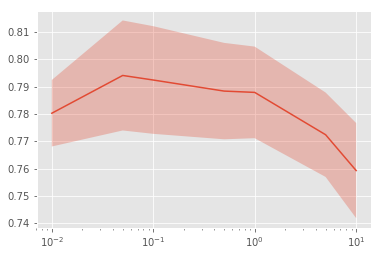

0.8844491932819486


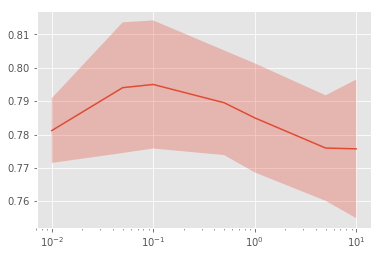

0.8876664138261291


array([0.75616691, 0.38150805, 0.44515437, ..., 0.47759155, 0.95424254,
       0.85674248])

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score

def plot_scores(optimizer):
    scores = [[item[0]['C'], 
               item[1], 
               (np.sum((item[2]-item[1])**2)/(item[2].size-1))**0.5] for item in optimizer.grid_scores_]
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    plt.show()
    
def write_answer_1(auc_1, auc_2):
    auc = (auc_1 + auc_2)/2
    with open("preprocessing_lr_answer1.txt", "w") as fout:
        fout.write(str(auc))
        
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
cv = 3
estimator = LogisticRegression('l2')
optimizer = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=3)

optimizer.fit(X_real_zeros_aggr, y_train) # Выборка с нулями (ответ 2)
plot_scores(optimizer)
auc_1 = roc_auc_score(y_test, optimizer.predict_proba(X_real_zeros_aggr_test)[:,1])
print auc_1 

optimizer.fit(X_real_mean_aggr, y_train) # Выборка со средними (ответ 1)
plot_scores(optimizer)
auc_2 = roc_auc_score(y_test, optimizer.predict_proba(X_real_mean_aggr_test)[:,1])
print auc_2 

write_answer_1(auc_2,auc_1)

optimizer.predict_proba(X_real_zeros_aggr)[:,1]


### Features scaling

Let's try somehow to improve the quality of the classification. To do this, let's look at the data itself:

/Users/VB/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.


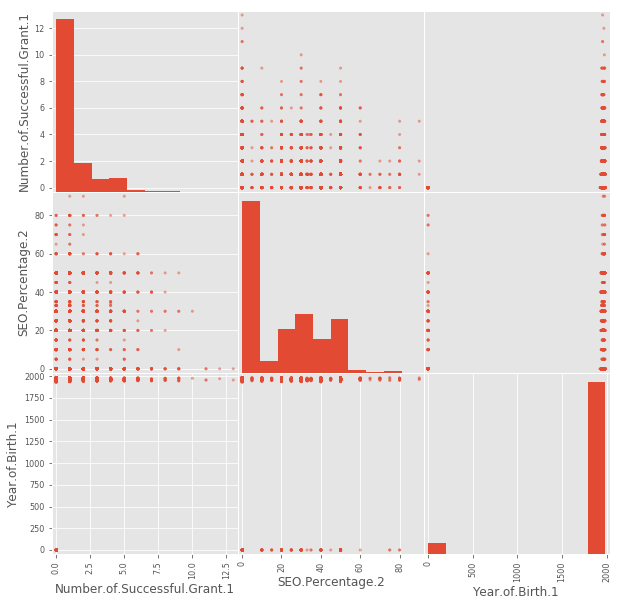

In [15]:
from pandas.tools.plotting import scatter_matrix

data_numeric = pd.DataFrame(X_train_real_zeros, columns=numeric_cols)
list_cols = ['Number.of.Successful.Grant.1', 'SEO.Percentage.2', 'Year.of.Birth.1']
scatter_matrix(data_numeric[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

As can be seen from the graphs, different characteristics vary greatly in absolute of values.

Standardization is carried out by deducting from each characteristic the mean value and normalization for a sample standard deviation:

$$ x^{scaled}_{id} = \dfrac{x_{id} - \mu_d}{\sigma_d}, \quad \mu_d = \frac{1}{N} \sum_{i=1}^l x_{id}, \quad \sigma_d = \sqrt{\frac{1}{N-1} \sum_{i=1}^l (x_{id} - \mu_d)^2} $$

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train_real_zeros)
X_train_real_scaled = scaler.transform(X_train_real_zeros)

scaler2 = StandardScaler().fit(X_test_real_zeros)
X_test_real_scaled = scaler.transform(X_test_real_zeros)





## Comparison of feature spaces

/Users/VB/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  app.launch_new_instance()


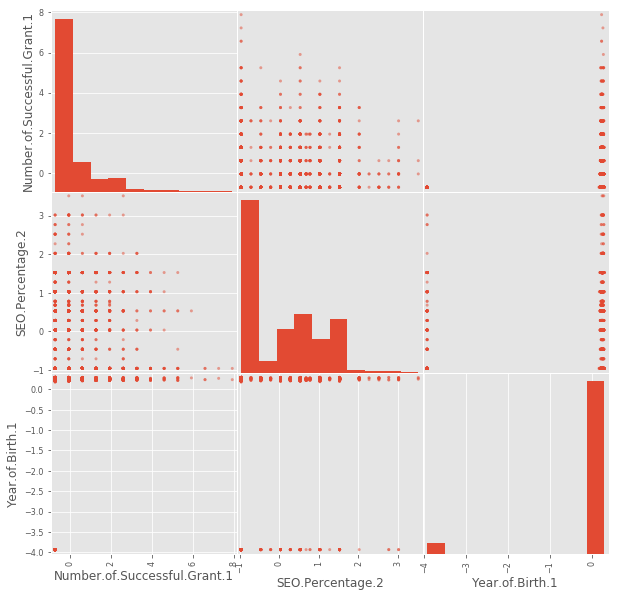

In [17]:
data_numeric_scaled = pd.DataFrame(X_train_real_scaled, columns=numeric_cols)
list_cols = ['Number.of.Successful.Grant.1', 'SEO.Percentage.2', 'Year.of.Birth.1']
scatter_matrix(data_numeric_scaled[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

As can be seen from the graphs, the properties of the characteristic space don't changed, but all values are now in approximately the same range, thereby increasing the interpretation of results, and also better combined with the ideology of regularization.

## Comparison of the quality of classification before and after scaling



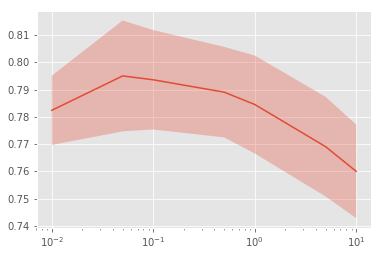

0.885044379082622


In [18]:
def write_answer_2(auc):
    with open("preprocessing_lr_answer2.txt", "w") as fout:
        fout.write(str(auc))
    
X_train_real_scaled_aggr = np.hstack((X_train_real_scaled,X_train_cat_oh))
X_test_real_scaled_aggr = np.hstack((X_test_real_scaled,X_test_cat_oh))

param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
cv = 3
estimator = LogisticRegression('l2')
optimizer = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=3)

optimizer.fit(X_train_real_scaled_aggr, y_train) 
plot_scores(optimizer)
auc_1 = roc_auc_score(y_test, optimizer.predict_proba(X_test_real_scaled_aggr)[:,1])
print auc_1 


write_answer_2(auc_1)


## Classes balancing

Algorithms of classification can be very sensitive to unbalanced classes.
Let's see if the classes are balanced in our training sample:

In [19]:
print(np.sum(y_train==0))
print(np.sum(y_train==1))

2316
1884


There are several ways to correct the situation, I will consider two of them:
- to give objects of a minority class a greater weight when training a classifier (discussed in the example above)
- to add some objects to the sample of the minority class until the number of objects in both classes become equal

In [20]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def write_answer_3(auc_1, auc_2):
    auc = (auc_1 + auc_2) / 2
    with open("preprocessing_lr_answer3.txt", "w") as fout:
        fout.write(str(auc))
        
print X_train_real_scaled_aggr.shape
optimizer = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=cv)
optimizer.fit(X_train_real_scaled_aggr, y_train)
auc_1 = roc_auc_score(y_test, optimizer.predict_proba(X_test_real_scaled_aggr)[:,1])
print auc_1 


np.random.seed(0)
indices_to_add = np.random.randint(len(y_train[y_train==1]),size = len(y_train[y_train==0])-len(y_train[y_train==1]))
X_train_real_scaled_aggr_to_add = X_train_real_scaled_aggr[y_train.as_matrix() == 1,:][indices_to_add,:]
print X_train_real_scaled_aggr.shape
print X_train_real_scaled_aggr_to_add.shape
y_train2 = np.concatenate((y_train,np.ones(len(indices_to_add))),axis=0)
print y_train.shape
print y_train2.shape

optimizer = GridSearchCV(LogisticRegression(class_weight=None), param_grid = param_grid, cv = cv)

X_train_scaled_aggr_added = np.vstack((X_train_real_scaled_aggr,X_train_real_scaled_aggr_to_add))
print X_train_scaled_aggr_added.shape
optimizer.fit(X_train_scaled_aggr_added, y_train2)

auc_2 = roc_auc_score(y_test, optimizer.predict_proba(X_test_real_scaled_aggr)[:,1])
print auc_2



(4200, 5606)
0.8871850681370189
(4200, 5606)
(432, 5606)
(4200,)
(4632,)
(4632, 5606)
0.8832711956057716


## Samples stratification



1. By analogy with the way it was done at the beginning of the notebook, let's break the samples X_real_zeros and X_cat_oh into the training and test, passing to the function
        train_test_split (...)
   optional parameter
       stratify = y
2. After this, I'm going to scale the new real samples, train the classifier and its hyperparameters using the cross-validation method, making corrections for unbalanced classes using scales. 
3. Evaluate the quality of the AUC ROC metric in the test sample.


In [21]:
def write_answer_4(auc):
    with open("preprocessing_lr_answer4.txt", "w") as fout:
        fout.write(str(auc))
        
(X_train_real_zeros, X_test_real_zeros,y_train, y_test) = train_test_split(X_real_zeros, y, test_size=0.3, stratify=y, random_state=0)
(X_train_cat_oh, X_test_cat_oh) = train_test_split(X_cat_oh, test_size=0.3, stratify=y, random_state=0)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train_real_zeros)
X_train_real_scaled = scaler.transform(X_train_real_zeros)
scaler2 = StandardScaler().fit(X_test_real_zeros)
X_test_real_scaled = scaler.transform(X_test_real_zeros)

X_train_real_scaled_aggr = np.hstack((X_train_real_scaled,X_train_cat_oh))
X_test_real_scaled_aggr = np.hstack((X_test_real_scaled,X_test_cat_oh))

optimizer = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=cv)
optimizer.fit(X_train_real_scaled_aggr, y_train)
auc_1 = roc_auc_score(y_test, optimizer.predict_proba(X_test_real_scaled_aggr)[:,1])

print auc_1



0.8793487130496221


Now we have dealt with the main stages of data preprocessing for linear classifiers.
The main stages:
- processing of missing values
- handling of categorical attributes
- stratification
- class balancing
- scaling

These data actions are recommended to be performed whenever you plan to use linear methods. The recommendation to fulfill many of these points is valid for other methods of machine learning.